In [1]:
import pandas as pd
import numpy as np
import cv2
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from keras.layers import Dense,Conv2D,MaxPooling2D,BatchNormalization,Dropout,Flatten
from keras.applications import DenseNet121,DenseNet201
import matplotlib.pyplot as plt
from keras.callbacks import ModelCheckpoint,EarlyStopping,LearningRateScheduler
from keras import optimizers

2024-02-21 17:09:22.043082: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2024-02-21 17:09:22.043183: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2024-02-21 17:09:22.154375: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [2]:
data_dir= '/kaggle/input/pc-parts-images-dataset-classification/pc_parts'

In [3]:
datagen= ImageDataGenerator(
    rotation_range=40,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    fill_mode='nearest',
    horizontal_flip=True,
    rescale=1./255,
    validation_split=0.2,
  )

In [4]:
train_generator= datagen.flow_from_directory( 
    data_dir,
    target_size=(256,256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset= 'training',
)

val_generator= datagen.flow_from_directory( 
    data_dir,
    target_size=(256,256),
    color_mode='rgb',
    class_mode='categorical',
    batch_size=32,
    shuffle=True,
    subset= 'validation')

Found 2629 images belonging to 14 classes.
Found 650 images belonging to 14 classes.


In [ ]:
import glob
import os
subfolder_path=glob.glob(data_dir+'/*',recursive=True)
text_labels=[]
for i in subfolder_path:
    a=os.path.basename(i)
    text_labels.append(a)
    
text_labels=sorted(text_labels)
text_labels

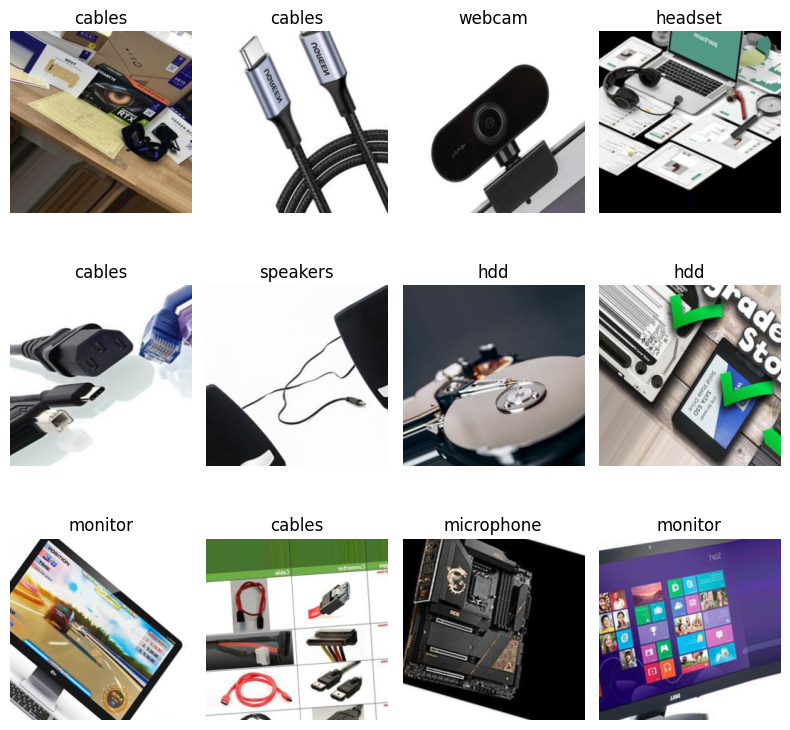

In [59]:
batch_images,batch_labels= train_generator.next()
plt.figure(figsize=(8,8))
for i in range (12):
    plt.subplot(3,4,i+1)
    plt.imshow(batch_images[i],cmap='gray')
    num_index= np.argmax(batch_labels[i])
    plt.title(text_labels[num_index])
    plt.axis('off')
plt.tight_layout()
plt.show()

In [6]:
model= Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),activation='relu',input_shape= (128,128,1)))
model.add(BatchNormalization())

model.add(Conv2D(filters=512,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))


model.add(Conv2D(filters=1024,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=1024,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Conv2D(filters=1024,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))

model.add(Flatten())
model.add(Dense(units=1024,activation='relu'))
model.add(Dense(units=512,activation='relu'))
model.add(Dense(units=256,activation='relu'))
model.add(Dense(units=14,activation='softmax'))

In [7]:
base_model = DenseNet201(weights='imagenet', include_top=False, input_shape=(256, 256, 3))

# Freeze the layers of the base model
for layer in base_model.layers:
    layer.trainable = False

model = Sequential([
    base_model,
    BatchNormalization(),
    
    Flatten(),
    
    Dense(256,activation='relu'),
    BatchNormalization(),
    Dense(128,activation='relu'),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(14,activation='softmax'),
])

74836368/74836368 [==============================] - 3s 0us/step


In [8]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 densenet201 (Functional)    (None, 8, 8, 1920)        18321984  
                                                                 
 batch_normalization_1 (Bat  (None, 8, 8, 1920)        7680      
 chNormalization)                                                
                                                                 
 flatten_1 (Flatten)         (None, 122880)            0         
                                                                 
 dense_4 (Dense)             (None, 256)               31457536  
                                                                 
 batch_normalization_2 (Bat  (None, 256)               1024      
 chNormalization)                                                
                                                                 
 dense_5 (Dense)             (None, 128)              

In [9]:
checkpoint= ModelCheckpoint(filepath='model_weights.keras',monitor='val_accuracy',save_best_only=True,save_weights_only=True,verbose=1)
earlystopping= EarlyStopping(monitor='val_accuracy',patience=5,restore_best_weights=True)

In [10]:
lr_scheduler= optimizers.schedules.ExponentialDecay(initial_learning_rate= 0.00001,decay_steps=2000,decay_rate=50)

In [11]:
model.compile(optimizer= optimizers.Adam(learning_rate=lr_scheduler),loss='categorical_crossentropy', metrics=['accuracy'])

In [15]:
model.fit(train_generator,epochs=10,batch_size=32,validation_data=val_generator,verbose=1,callbacks=[checkpoint,earlystopping])

Epoch 1/10
83/83 [==============================] - ETA: 0s - loss: 1.0111 - accuracy: 0.7041
Epoch 1: val_accuracy did not improve from 0.73846
83/83 [==============================] - 46s 562ms/step - loss: 1.0111 - accuracy: 0.7041 - val_loss: 0.9204 - val_accuracy: 0.7308
Epoch 2/10
83/83 [==============================] - ETA: 0s - loss: 0.9958 - accuracy: 0.7090
Epoch 2: val_accuracy did not improve from 0.73846
83/83 [==============================] - 45s 541ms/step - loss: 0.9958 - accuracy: 0.7090 - val_loss: 0.9287 - val_accuracy: 0.7354
Epoch 3/10
83/83 [==============================] - ETA: 0s - loss: 0.9722 - accuracy: 0.7216
Epoch 3: val_accuracy improved from 0.73846 to 0.74462, saving model to model_weights.keras
83/83 [==============================] - 46s 556ms/step - loss: 0.9722 - accuracy: 0.7216 - val_loss: 0.9329 - val_accuracy: 0.7446
Epoch 4/10
83/83 [==============================] - ETA: 0s - loss: 0.9249 - accuracy: 0.7341
Epoch 4: val_accuracy did not impr

In [16]:
model.load_weights('/kaggle/working/model_weights.keras')
model.evaluate(val_generator)

21/21 [==============================] - 9s 423ms/step - loss: 0.9034 - accuracy: 0.7369


[0.9033708572387695, 0.736923098564148]

In [17]:
prediction=model.predict(val_generator)

21/21 [==============================] - 9s 413ms/step


In [51]:
import glob
import os
subfolder_path=glob.glob(data_dir+'/*',recursive=True)
text_labels=[]
for i in subfolder_path:
    a=os.path.basename(i)
    text_labels.append(a)
    
text_labels=sorted(text_labels)
text_labels

['cables',
 'case',
 'cpu',
 'gpu',
 'hdd',
 'headset',
 'keyboard',
 'microphone',
 'monitor',
 'motherboard',
 'mouse',
 'ram',
 'speakers',
 'webcam']

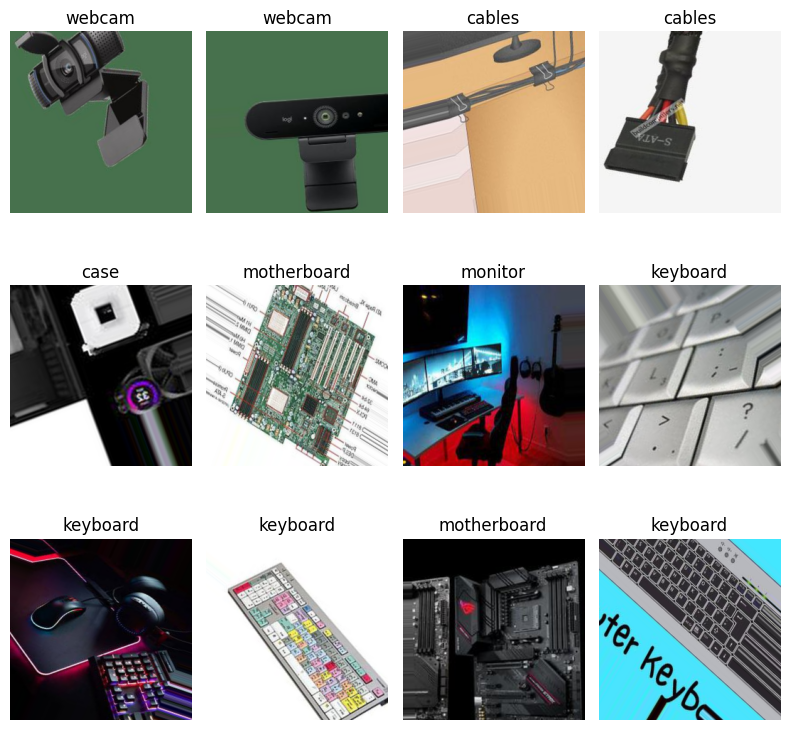

In [57]:
val_images,val_labels= val_generator.next()

plt.figure(figsize=(8,8))
for i in range(12):
    plt.subplot(3,4,i+1)
    plt.imshow(val_images[i])
    num_index= np.argmax(val_labels[i])
    plt.title(text_labels[num_index])
    plt.axis('off')
    
plt.tight_layout()
plt.show()

In [60]:
model.save('PC_Parts_Classification.keras')